# Importing Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, Model
import numpy as np
import os



# Setting up the gpu 

In [ ]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Loading the Dataset

In [ ]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# lets normalize it to 0-1
x_train = x_train / 255.0
x_test = x_test / 255.0


# Making the function

In [ ]:
# this one convert the image to grayscale  
def rgb_to_grayscale(images):
    return tf.image.rgb_to_grayscale(images).numpy()


In [ ]:
x_train_gray = rgb_to_grayscale(x_train) #converting both to grayscale for train and test
x_test_gray = rgb_to_grayscale(x_test)

In [ ]:
# Lets visualise the grayscale and oroginal ones
def visualize_samples(gray_images, color_images, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(gray_images[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(color_images[i])
        plt.axis('off')
    plt.show()


# Using the Visuals

Num GPUs Available:  1
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


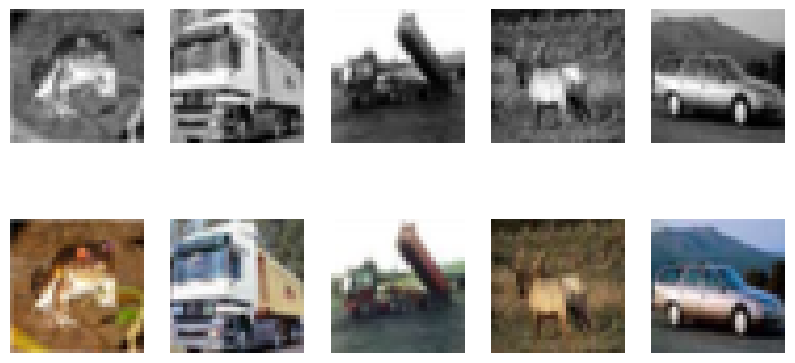

Grayscale training data shape: (50000, 32, 32, 1)
Color training data shape: (50000, 32, 32, 3)


In [1]:

visualize_samples(x_train_gray, x_train)

# convert the grayscale image to 1 channel
x_train_gray = x_train_gray.reshape(-1, 32, 32, 1)
x_test_gray = x_test_gray.reshape(-1, 32, 32, 1)

print(f"grayscale training data shape: {x_train_gray.shape}")
print(f"color training data shape: {x_train.shape}")

# lets make the model 

In [2]:

# make the model
def build_colorization_model(input_shape=(32, 32, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Output layer: 3 channels for RGB
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    return model


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,100,291 (11.83 MB)

 Trainable params: 3,100,291 (11.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# build the model
input_shape = (32, 32, 1)  # grayscale input
model = build_colorization_model(input_shape)
model.summary()

In [ ]:
# lets compile it and use adam and loss to mse
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
# we use 20 becuase of my gpu heating
batch_size = 64
epochs = 20

In [ ]:
# Split the dataset
x_val_gray = x_train_gray[-5000:]  # Use the last 5000 samples for validation
x_val_color = x_train[-5000:]

In [ ]:
x_train_gray_small = x_train_gray[:-5000]  # Use the remaining for training
x_train_color_small = x_train[:-5000]

In [ ]:
# Define callbacks for saving the model and early stopping
# Save as a Keras model with the `.keras` extension
checkpoint = ModelCheckpoint(
    "colorization_model.keras", monitor="val_loss", save_best_only=True, verbose=1
)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)


In [4]:

# Train the model
history = model.fit(
    x_train_gray_small,
    x_train_color_small,
    validation_data=(x_val_gray, x_val_color),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping],
    verbose=1,
)



Epoch 1/20


I0000 00:00:1733927897.986486      87 service.cc:145] XLA service 0x78addc010960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733927897.986538      87 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 18/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4347 - loss: 0.0617 

I0000 00:00:1733927901.316451      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4548 - loss: 0.0273
Epoch 1: val_loss improved from inf to 0.01347, saving model to colorization_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.4548 - loss: 0.0273 - val_accuracy: 0.4747 - val_loss: 0.0135
Epoch 2/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4958 - loss: 0.0124
Epoch 2: val_loss improved from 0.01347 to 0.01131, saving model to colorization_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4958 - loss: 0.0124 - val_accuracy: 0.5084 - val_loss: 0.0113
Epoch 3/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5089 - loss: 0.0106
Epoch 3: val_loss improved from 0.01131 to 0.01012, saving model to colorization_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5089 - loss: 0.0106 - val_accuracy: 0.5099 - val_loss: 0.0101
Epoch 4/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5109 - loss: 0.0099
Epoch 4: val_loss improved from 0.0101

In [ ]:

# lets load the model
model = tf.keras.models.load_model("colorization_model.keras")

# Predict on the test set
test_predictions = model.predict(x_test_gray)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


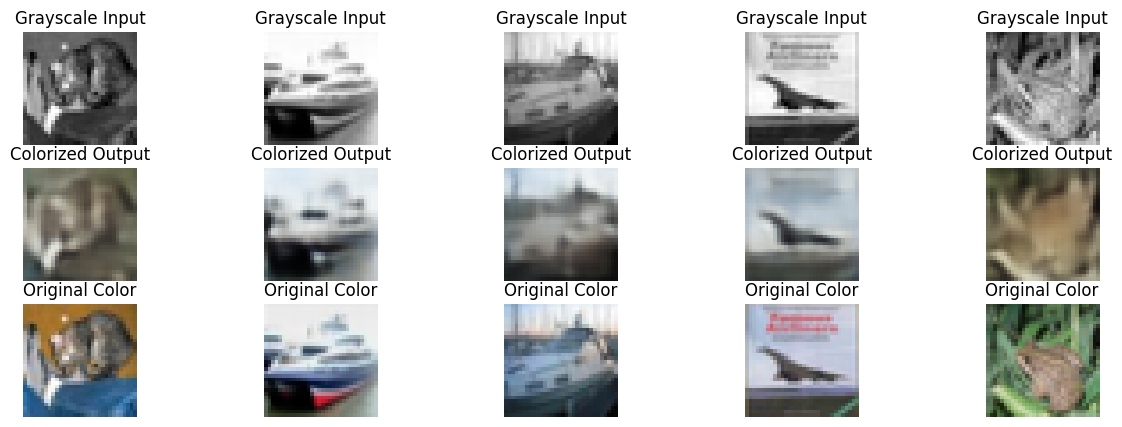

In [5]:


# extra function to display grayscale input, model output, and original color
def display_predictions(gray_images, predicted_color, true_color, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # grayscale Input
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(gray_images[i].squeeze(), cmap='gray')
        plt.title("Grayscale Input")
        plt.axis("off")
        
        # predicted Colorized Output
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(predicted_color[i])
        plt.title("Colorized Output")
        plt.axis("off")
        
        # original Color
        plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
        plt.imshow(true_color[i])
        plt.title("Original Color")
        plt.axis("off")
    
    plt.show()


In [ ]:
# Clip predictions to [0, 1] range and display results
test_predictions_clipped = np.clip(test_predictions, 0, 1)
display_predictions(x_test_gray, test_predictions_clipped, x_test)


In [49]:

# Call the function to colorize and save the video
colorize_video(input_video_path, output_video_path)

print(f"Colorized video saved at: {output_video_path}")

Colorized video saved at: /kaggle/working/colorized_video.avi


In [1]:
import os

# Path to the directory
path = '/kaggle/working/'

# List files and directories in the path
files = os.listdir(path)

# Display the list of files
files


['.virtual_documents']